<a href="https://colab.research.google.com/github/zeliky/deep-learning-fp/blob/main/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
from scipy.io import loadmat
import numpy as np
from PIL import Image,ImageShow
import matplotlib.pyplot as plt
import re
import os
import math
import random
import tensorflow as tf
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import Sequence, to_categorical
from concurrent.futures import ThreadPoolExecutor

In [ ]:
drive.mount('/gdrive')


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
BASE_PATH  = '/gdrive/MyDrive/deep-learning/final-project/data-sets/'
ORIGINAL_IMAGES = BASE_PATH + "0_Images/"
ROTATED_IMAGES =  BASE_PATH + "1_ImagesRotated/"
MEDIAN_BW_IMAGES =  BASE_PATH + "2_ImagesMedianBW/"
LINES_REMOVED_BW_IMAGES =  BASE_PATH + "3_ImagesLinesRemovedBW/"
LINES_REMOVED_IMAGES =  BASE_PATH + "4_ImagesLinesRemoved/"
DARK_LINES =  BASE_PATH + "5_DataDarkLines/"
SAMPLE_FILE_PATTERN = "lines{}_Page_{}.jpg"
METADATA_PATTERN = "lines{}_Page_{}.mat"
MODEL_CHECKPOINT_PATH = BASE_PATH + "model_checkpoints/"

NUMPY_STORAGE=  BASE_PATH +"numpy_storage/{}_train_validation.npz"
ALLOWED_TYPES = [ORIGINAL_IMAGES,ROTATED_IMAGES, MEDIAN_BW_IMAGES, LINES_REMOVED_BW_IMAGES, LINES_REMOVED_IMAGES]
TRAIN_TYPES =  [ LINES_REMOVED_BW_IMAGES, LINES_REMOVED_IMAGES]
VALIDATE_TYPES =  [ ROTATED_IMAGES, MEDIAN_BW_IMAGES]
LINE_SHAPE = (225, 4965)
INPUT_SQUARE = (227, 227)

MODE_TRAIN = 'train'
MODE_VALIDATION = 'validation'
MODE_TEST = 'test'


In [ ]:
class MetaData:
  @staticmethod
  def from_mat_data(data):
    metadata = MetaData()
    SCALE_FACTOR = data['SCALE_FACTOR'].flatten()[0]
    peaks_indices = data['peaks_indices'].flatten()
    metadata.min_y  = SCALE_FACTOR * min(peaks_indices)
    metadata.max_y  = SCALE_FACTOR *  max(peaks_indices)
    metadata.peaks_indices = [SCALE_FACTOR*a - metadata.min_y for a in  peaks_indices]
    metadata.index_of_max_in_peak_indices = data['index_of_max_in_peak_indices'].flatten()[0]
    metadata.delta = data['delta'].flatten()[0]
    metadata.top_test_area = data['top_test_area'].flatten()[0] - metadata.min_y
    metadata.bottom_test_area = data['bottom_test_area'].flatten()[0] - metadata.min_y
    metadata.total_lines = len(metadata.peaks_indices)
    return metadata

  def __repr__(self):
    return str(self.__dict__)


In [ ]:
class ModelOptions:
    def __init__(self, **kwargs):
        self.num_classes = kwargs.get('num_classes', 10)
        self.batch_size = kwargs.get('batch_size', 100)
        self.image_height = kwargs.get('image_height', 50)
        self.image_width = kwargs.get('image_width', 50)
        self.num_channels = kwargs.get('num_channels', 1)
        self.max_sequence_length = kwargs.get('max_sequence_length', 32)
        self.random_shuffle_amount = kwargs.get('random_shuffle_amount', 0)
        self.lstm_units = kwargs.get('lstm_units', 5)
        self.max_embedding_samples = kwargs.get('max_embedding_samples', 5)

    def __repr__(self):
        return str(self.__dict__)

In [ ]:
class DataSet:
    def __init__(self):
        self.user_files = {}
        self.metadata = {}
        self._build_index()
        self.reset()

    def reset(self):
        self.images = {}

    def load_image(self, path, user_id):
        bin, id = self.user_files[user_id]
        image_type = self._image_type(path)

        file_name = SAMPLE_FILE_PATTERN.format(bin, id)
        image_path = "{}{}".format(path, file_name)
        image_metadata = self._get_cached_metadata(user_id)
        if image_metadata is None:
            image_metadata = self.image_metadata(user_id)
            self._cache_metadata(user_id, image_metadata)

        user_file = self._get_cached_image(image_type, user_id)
        if user_file is None:
            print('loading image from {}'.format(image_path))
            with open(image_path, 'r') as f:
                im = Image.open(image_path)
                user_file = UserFile(im, image_metadata)
                self._cache_image(image_type, user_id, user_file)
        return user_file

    def image_metadata(self, user_id):
        bin, id = self.user_files[user_id]
        file_name = METADATA_PATTERN.format(bin, id)
        metadata_path = "{}{}".format(DARK_LINES, file_name)
        # print(metadata_path)
        data = loadmat(metadata_path)
        return MetaData.from_mat_data(data)

    def _image_type(self, path):
        reg = re.search(r'\d+', path)
        return int(reg.group())


    def _build_index(self):
        directory_files = os.listdir(ORIGINAL_IMAGES)
        for idx, fname in enumerate(directory_files):
            pattern = re.search(r'lines(\d+)_Page_(\d+)', fname.replace(BASE_PATH, ''))
            self.user_files[idx] = (pattern.group(1), pattern.group(2))

    def _get_cached_image(self, image_type, user_id):
        if image_type in self.images and user_id in self.images[image_type]:
            return self.images[image_type][user_id]
        return None

    def _cache_image(self, image_type, user_id, image):
        if image_type not in self.images:
            self.images[image_type] = {}
        if user_id not in self.images[image_type]:
            self.images[image_type][user_id] = image

    def _get_cached_metadata(self, user_id):
        if user_id in self.metadata:
            return self.metadata[user_id]
        return None

    def _cache_metadata(self, user_id, metadata: MetaData):
        self.metadata[user_id] = metadata


# -------------------------------------------------------------------------------
#should be kept global so it will be shared by multi processes
full_data_set = DataSet()

In [ ]:
class UserFile:
    def __init__(self, im, metadata):
        # image_arr = np.asarray(im.getchannel(0).getdata())
        self.im = im.copy()
        if im.mode != 'L':
            im = im.convert(mode='L')
        image_arr = np.asarray(im.getchannel(0))
        # image_arr = image_arr.reshape(im.height, im.width)
        # print(image_arr.shape)
        self.data = image_arr[metadata.min_y: metadata.max_y, :]
        self.metadata = metadata

    def get_testing_line(self):
        y_range = (self.metadata.top_test_area, self.metadata.bottom_test_area)
        return self.data[y_range[0]:y_range[1], :]

    def get_test_line_idx(self):
        for i in range(1, self.metadata.total_lines):
            if self.is_test_line(i):
                return i

    def get_all_lines(self, threshold=2000):
        for i in range(1, self.metadata.total_lines):
            yield self.get_line(i)

    def get_line(self, line_idx):
        y_range = (self.metadata.peaks_indices[line_idx - 1:line_idx + 1])
        return self.data[y_range[0]:y_range[1] + 30, :]

    def is_test_line(self, line_idx):
        bounderies = self.metadata.peaks_indices[line_idx - 1:line_idx + 1]
        return abs(int(bounderies[0]) - self.metadata.top_test_area) < 50 and abs(
            int(bounderies[1]) - self.metadata.bottom_test_area) < 50

    def show(self):
        image = Image.fromarray(self.data.astype(np.uint8))
        image.show()


In [ ]:
class UserDataset:
    def __init__(self, user_id):
        self.user_id = user_id
        self.train_lines = []
        self.validation_lines = []
        self.all_lines = []
        self.test_line = None
        self.split_points = {}
        self.min_width = 20

    def warmup(self):
        e = ThreadPoolExecutor(max_workers=len(ALLOWED_TYPES))
        futures = [e.submit(full_data_set.load_image, t, self.user_id) for t in ALLOWED_TYPES]
        results = [f.result() for f in futures]
        self.split_dataset()

    def split_dataset(self, train_split=0.8):
        bw_image = full_data_set.load_image(LINES_REMOVED_BW_IMAGES, self.user_id)
        self.train_lines, self.validation_lines = select_train_validation_lines(bw_image)
        self.test_line = bw_image.get_test_line_idx()
        self.all_lines = sorted(self.train_lines + self.validation_lines)

    def get_train_data(self, target_size):
        print(f"train lines {self.train_lines}")
        for img_path in ALLOWED_TYPES:
            print(img_path)
            for line_idx in self.train_lines:
                # print(f"get_train_data user:{self.user_id} -  line {img_path}::{line_idx}")
                sequence = self.get_line_sequence(img_path, line_idx, target_size)
                yield sequence
        return

    def get_validation_data(self, target_size):
        print(f"validation lines {self.validation_lines}")
        for line_idx in self.validation_lines:
            # print(f"get_validation_data line {ORIGINAL_IMAGES}::{line_idx}")
            yield self.get_line_sequence(ORIGINAL_IMAGES, line_idx, target_size)
        return

    def get_testing_data(self, target_size):
        print(f"testing line {self.test_line}")
        # print(f"get_testing_data user:{self.user_id} line {ORIGINAL_IMAGES}::{self.test_line}")
        yield self.get_line_sequence(ORIGINAL_IMAGES, self.test_line, target_size)
        return

    def get_letters(self, img_path, line_idx, target_size):

        split_points = self._get_characters_split_points(line_idx)
        user_file = full_data_set.load_image(img_path, self.user_id)
        line = normalized_line(user_file.get_line(line_idx))
        # print(f"split_points {line_idx}: {split_points}")
        prev_width, prev_x = None, None
        for (x, y, w, h) in split_points:
            if prev_x is not None:
                x = prev_x
                w += prev_width
                # print(f"get_letters:width after join {w}")
                if w > self.min_width:
                    prev_width, prev_x = None, None

            if w < self.min_width:
                # print(f"get_letters:width {w}")
                prev_x = x
                prev_width = w
                continue

            img = line[:, x:x + w]
            # print(f"get_letter shape {img.shape}")
            thumbnail = create_thumbnail(img, target_size)
            np_im = np.array(thumbnail, dtype=np.float32) / 255
            np_img = np_im.reshape(target_size[0], target_size[1], 1)
            yield np_img
        return

    def get_line_sequence(self, img_path, line_idx, target_size):
        sequence = []
        for np_img in self.get_letters(img_path, line_idx, target_size):
            sequence.append(np_img)
        return sequence

    def DEP_document_letters_generator(self, mode, target_size, original_only=False):
        types = ALLOWED_TYPES if original_only else [ORIGINAL_IMAGES]
        lines =[]
        if mode == MODE_TRAIN:
            lines = self.train_lines
        elif mode == MODE_VALIDATION:
            lines = self.validation_lines
        for img_path in types:
            for line_idx in lines:
                for np_img in self.get_letters(img_path, line_idx, target_size):
                    print(f"{img_path}: u{self.user_id} l:{line_idx}")
                    yield np_img
        return

    def random_letters_generator(self, mode, target_size, random_shuffle_amount=1, original_only=False):
      while True:
        types = ALLOWED_TYPES if not original_only else [ORIGINAL_IMAGES]

        lines =[]
        if mode == MODE_TRAIN:
            lines = self.train_lines
        elif mode == MODE_VALIDATION:
            lines = self.validation_lines
        img_path = random.choice(types)
        user_file = full_data_set.load_image(img_path, self.user_id)
        line_idx = random.choice(lines)
        line = normalized_line(user_file.get_line(line_idx))
        split_points = self._get_characters_split_points(line_idx)
        (x, y, w, h) = random.choice(split_points)

        img = line[:, x:x + w]
        thumbnails = [create_thumbnail(img, target_size) for _ in range(random_shuffle_amount)]
        for i, thumbnail in enumerate(thumbnails):
          np_im = np.array(thumbnail, dtype=np.float32) / 255
          np_img = np_im.reshape(target_size[0], target_size[1], 1)
          #print(f"{img_path}: u:{self.user_id} l:{line_idx} x:{x}-{x+w} rand:{i}")
          yield np_img


    def _get_characters_split_points(self, idx):
        if idx in self.split_points:
            return self.split_points[idx]
        img = full_data_set.load_image(LINES_REMOVED_BW_IMAGES, self.user_id)
        line = normalized_line(img.get_line(idx))
        binary = np.where(line > 30, 1, 0).astype('uint8')
        rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (8, 8))
        dilation = cv2.dilate(binary, rect_kernel, iterations=1)
        contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        split_points = []
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            if w > self.min_width:
                split_points.append((x, y, w, h))

        self.split_points[idx] = sorted(split_points, key=lambda tup: tup[0])
        # print( self.split_points[idx])
        return self.split_points[idx]

    def DEP_get_characters_split_points(self, idx):
        if idx in self.split_points:
            return self.split_points[idx]

        img = full_data_set.load_image(LINES_REMOVED_BW_IMAGES, self.user_id)
        line = normalized_line(img.get_line(idx))

        sum_vector = np.sum(line, axis=0)
        threshold = 0.05 * np.mean(sum_vector)
        split_points = []
        section, last_split = None, None

        for idx, val in enumerate(sum_vector):
            value_type = 0 if val < threshold else 1
            if section is None:
                section = value_type
                last_split = idx
            elif section != value_type and idx - last_split > 8:
                split_points.append(idx)
                last_split = idx
                section = value_type
        self.split_points[idx] = split_points
        return split_points

In [ ]:
def image_dots(img_data,threshold=50):
  height, width = img_data.shape
  for i in range(height):
    line =''
    for j in range(width):
      if img_data[i,j]<threshold:
        line += ' '
      else:
        line += '.'
    print(line)

def show_line(line_data):
    image = Image.fromarray(line_data.astype(np.uint8))
    image.show()


def is_empty_line(line_data, threshold=2000):
    values = line_data.flatten()
    sum = values[values < 50].sum()
    # print("is_empty_line {}".format(sum))
    return sum < threshold


def normalized_line(line_data):
    desired_shape = LINE_SHAPE
    # normalized_data =  (255 - line_data) / 255.0
    normalized_data = (255 - line_data)
    pad_rows = max(0, desired_shape[0] - normalized_data.shape[0])
    pad_cols = max(0, desired_shape[1] - normalized_data.shape[1])

    padded_array = np.pad(normalized_data, ((0, pad_rows), (0, pad_cols)), mode='constant')
    return padded_array


def select_train_validation_lines(user_image, train_split=0.8):
    rows = []
    for i, line in enumerate(user_image.get_all_lines()):
        idx = i + 1
        if not user_image.is_test_line(idx) and not is_empty_line(line):
            rows.append(idx)

    random.shuffle(rows)
    split_idx = int(len(rows) * train_split)
    return (rows[0:split_idx], rows[split_idx:])


def split_and_shuffle_array(arr, split_points):
    chunks = split_array(arr, split_points)
    np.random.shuffle(chunks)
    shuffled_array = np.concatenate(chunks, axis=1)
    return shuffled_array


def split_array(arr, split_points):
    chunks = []
    start_idx = 0
    for end_idx in split_points:
        chunk = arr[:, start_idx:end_idx]
        chunks.append(chunk)
        start_idx = end_idx
    last_chunk = arr[:, start_idx:]
    chunks.append(last_chunk)
    return chunks


def create_thumbnail(image_array, target_size):
    height, width = image_array.shape
    target_height, target_width = target_size
    org_image = Image.fromarray(image_array)

    random_scale_w = random.uniform(0.6, 1.2)
    random_scale_h = random.uniform(0.6, 1.2)
    random_rotate =  random.randint(-20, 20)
    org_image_rs = org_image.resize((int(width*random_scale_w) , int(height*random_scale_h)),  Image.NEAREST)
    org_image_ro = org_image_rs.rotate(random_rotate, Image.NEAREST,expand=True)

    canvas = Image.new("L", (height, height), 0)
    if width < height:
        left = (height - width) // 2
        top = 0
        canvas.paste(org_image_ro, (left, top))
    else:
        scale_factor = height / width
        s_width = round(scale_factor * width)
        s_height = round(scale_factor * height)
        resized_image = org_image_ro.resize((s_width, s_height), Image.NEAREST)
        left = (height - s_width) // 2
        top = 0
        canvas.paste(resized_image, (left, top))
        del resized_image

    del org_image_rs
    del org_image_ro
    del org_image


    thumbnail = canvas.resize((target_width, target_height), Image.NEAREST)
    return thumbnail


def show_sequence(the_images):
    l = len(the_images)
    dim = math.ceil(math.sqrt(l))
    plt.clf()
    fig, axs = plt.subplots(dim, dim, figsize=(10, 10))
    k = l - 1
    for i in range(0, dim):
        for j in range(0, dim):
            img = the_images[k]
            axs[i, j].imshow(img, cmap='gray')
            axs[i, j].axis('off')
            k -= 1
            if k == 0:
                plt.show()
                return

def show_triplet(triplets):
    plt.clf()
    fig, axs = plt.subplots(1, 3, figsize=(5, 5))

    for k in range(0, 3):
        img = triplets[k]
        axs[k].imshow(img, cmap='gray')
        axs[k].axis('off')

    plt.show()

def pad_sequences(max_length, sequences, image_height, image_width, num_channels):
    # Pad sequences to have the same length (pad with zero images)
    padded_sequences = []
    for sequence in sequences:
        seq_len = len(sequence)
        if seq_len == 0:
            continue
        if seq_len > max_length:
            sequence = sequence[:max_length]
            seq_len = len(sequence)

        num_padding = max_length - seq_len
        if num_padding > 0:
            sequence = np.concatenate(
                [sequence, np.zeros((num_padding, image_height, image_width, num_channels))])
        padded_sequences.append(sequence)
    return np.array(padded_sequences)

In [ ]:
class FinalStopIteration(StopIteration):
    def __init__(self, *args: object) -> None:
        super().__init__(*args)


In [ ]:
class DataGeneratorsCollection:
    def __init__(self, options: ModelOptions):
        self.active_generators = None
        self.random_shuffle_amount = options.random_shuffle_amount
        self.input_shape = (options.image_height,options.image_width)
        self.users_ds = {}
        self.reset_generators()

    def reset_generators(self):
        self.active_generators = {
            'train': {},
            'valid': {},
            'test': {}
        }

    def get_user_ds(self, user_id):
        if user_id not in self.users_ds:
            uds = UserDataset(user_id)
            uds.warmup()
            self.users_ds[user_id] = uds
        return self.users_ds[user_id]

    def train_lines_amount(self, user_id):
        uds = self.get_user_ds(user_id)
        return len(uds.train_lines)

    def validation_lines_amount(self, user_id):
        uds = self.get_user_ds(user_id)
        return len(uds.validation_lines)

    def get_train_generator(self, user_id):
        if user_id not in self.active_generators['train']:
            uds = self.get_user_ds(user_id)
            self.active_generators['train'][user_id] = uds.get_train_data(target_size=self.input_shape)
        return self.active_generators['train'][user_id]

    def get_validation_generator(self, user_id):
        if user_id not in self.active_generators['valid']:
            uds = self.get_user_ds(user_id)
            self.active_generators['valid'][user_id] = uds.get_validation_data(target_size=self.input_shape)
        return self.active_generators['valid'][user_id]

    def get_test_generator(self, user_id):
        if user_id not in self.active_generators['test']:
            uds = self.get_user_ds(user_id)
            self.active_generators['test'][user_id] = uds.get_testing_data(target_size=self.input_shape)
        return self.active_generators['test'][user_id]

    def deactivate_generator(self, gtype, user_id):
        if user_id in self.active_generators[gtype]:
            del self.active_generators[gtype][user_id]


In [ ]:
class BaseSequenceGenerator(Sequence):
    def __init__(self, user_ids, model_options: ModelOptions, generators: DataGeneratorsCollection):
        self.active_user_ids = [i for i in user_ids]
        self.user_ids = [i for i in user_ids]
        self.generators = generators
        self.num_classes = max(user_ids) + 1
        self.options = model_options

    def next_sequence(self):
        raise 'Not implemented'

    def total_lines(self):
        raise 'Not implemented'

    def get_random_user(self):
        # print(f"users len{len(self.user_ids)}")
        if len(self.active_user_ids):
            return np.random.choice(self.active_user_ids)
        raise FinalStopIteration()

    def __getitem__(self, index):
        labels = []
        sequences = []
        for _ in range(self.options.batch_size):
            try:
                user_id, sequence = self.next_sequence()
                if sequence is None:
                    # print(f"user  {user_id} has finished his dataset ")
                    self.active_user_ids.remove(user_id)
                    continue
                labels.append(user_id)
                sequences.append(sequence)
            except FinalStopIteration:
                print("NO MORE DATA!")
                break

        if len(sequences) == 0:
            return tf.convert_to_tensor([]), tf.convert_to_tensor([])
        padded_sequences = pad_sequences(self.options.max_sequence_length, sequences, self.options.image_height,
                                         self.options.image_width, self.options.num_channels)

        batch_sequences = np.array(padded_sequences)
        batch_labels = np.array(labels)
        print(f"Batch Shape: {batch_sequences.shape}, Label Shape: {batch_labels.shape}")

        return tf.convert_to_tensor(batch_sequences), tf.convert_to_tensor(batch_labels)

    def __len__(self):
        sfl_count = self.generators.random_shuffle_amount if self.generators.random_shuffle_amount > 0 else 1
        samples = self.total_lines() * sfl_count * len(ALLOWED_TYPES)
        epoch_len = samples // self.options.batch_size
        print(f'epoch_len={epoch_len}')
        return max(1, epoch_len)

    def on_epoch_end(self):
        self.generators.reset_generators()
        self.active_user_ids = [i for i in self.user_ids]


class TrainSequenceGenerator(BaseSequenceGenerator):
    def next_sequence(self):
        user_id = self.get_random_user()
        sequence = None
        try:
            sequence = next(self.generators.get_train_generator(user_id))
            return user_id, sequence
        except StopIteration:
            self.generators.deactivate_generator('train', user_id)
        return user_id, None

    def total_lines(self):
        total_lines = 0
        for user_id in self.active_user_ids:
            total_lines += self.generators.train_lines_amount(user_id)
        return total_lines


class ValidationSequenceGenerator(BaseSequenceGenerator):
    def next_sequence(self):
        sequence = None
        user_id = self.get_random_user()
        try:
            sequence = next(self.generators.get_validation_generator(user_id))
            return user_id, sequence
        except StopIteration:
            self.generators.deactivate_generator('valid', user_id)
        return user_id, None

    def total_lines(self):
        total_lines = 0
        for user_id in self.active_user_ids:
            total_lines += self.generators.validation_lines_amount(user_id)
        return total_lines


class TestSequenceGenerator(BaseSequenceGenerator):
    def next_sequence(self):
        sequence = None
        user_id = self.get_random_user()
        try:
            sequence = next(self.generators.get_test_generator(user_id))
            return user_id, sequence
        except StopIteration:
            self.generators.deactivate_generator('test', user_id)
        return user_id, None

    def total_lines(self):
        total_lines = 0
        return len(self.active_user_ids)

In [ ]:
class BaseLetterGenerator(Sequence):
    def __init__(self, mode, user_ids, options: ModelOptions):
        self.options = options
        self.user_ids = [i for i in user_ids]
        self.id_to_class = {user_id: i for i, user_id in enumerate(user_ids)}
        self.input_shape = (options.image_height, options.image_width)
        self.random_shuffle_amount = options.random_shuffle_amount
        self.users_ds = {}
        self.generators = {}
        self.mode = mode

    def __len__(self):
        return self.options.max_embedding_samples

    def on_epoch_end(self):
        self.generators = {}

    def reset_generators(self):
        self.generators = {}

    def get_user_ds(self, user_id):
        if user_id not in self.users_ds:
            uds = UserDataset(user_id)
            uds.warmup()
            self.users_ds[user_id] = uds
        return self.users_ds[user_id]

    def get_letters_generator(self, user_id, is_anchor=False):
        key = f"anc{user_id}" if is_anchor else str(user_id)
        if key not in self.generators:
            print(f"new generator for {user_id} anchor{is_anchor}")
            uds = self.get_user_ds(user_id)
            self.generators[key] = uds.random_letters_generator(mode=self.mode, target_size=self.input_shape,
                                                                  original_only=is_anchor, random_shuffle_amount=self.random_shuffle_amount)
        return self.generators[key]


class LettersGenerator(BaseLetterGenerator):
    def __init__(self, mode, user_ids, options: ModelOptions):
        super().__init__(mode, user_ids, options)

    def __len__(self):
        lines = 20
        users = len(self.user_ids)
        letters = 50
        random_shuffle_amount = self.options.random_shuffle_amount
        types = len(ALLOWED_TYPES)

        total_batches = (types * lines * users * letters* random_shuffle_amount) // self.options.batch_size
        #print(f"LettersGenerator __len__ {total_batches}")
        return total_batches

    def __getitem__(self, index):
        batch, labels = [], []
        users_count = len(self.user_ids)
        for s in range(self.options.batch_size):
            user_id = random.choice(self.user_ids)
            letter = next(self.get_letters_generator(user_id))
            batch.append(letter)
            labels.append(to_categorical(self.id_to_class[user_id], num_classes=users_count))
            # labels.append(self.id_to_class[user_id]+1)

        if len(batch) == 0:
            batch = np.zeros((self.options.batch_size, self.options.image_height, self.options.image_width, 1))
            labels = np.zeros((self.options.batch_size,))
        #print(f"LettersGenerator batch: {len(batch)}")
        return np.asarray(batch), np.asarray(labels)


class TripletsGenerator(BaseLetterGenerator):
    def __init__(self, mode, user_ids, options: ModelOptions):
        super().__init__(mode, user_ids, options)

    def __getitem__(self, index):
        batch, labels = [], []
        for _ in range(self.options.batch_size):
            positive_user, negative_user_id = random.sample(self.user_ids, 2)
            for triplet in self.get_triplets(positive_user, negative_user_id):
                if triplet is None:
                    positive_user, negative_user_id = random.sample(self.user_ids, 2)
                    continue
                batch.append(triplet)
                labels.append(positive_user)

        return np.asarray(batch), np.asarray(labels)

    def get_triplets(self, positive_user, negative_user_id):
        anchor_generator = self.get_letters_generator(positive_user, True)
        positive_generator = self.get_letters_generator(positive_user, False)
        negative_generator = self.get_letters_generator(negative_user_id, False)
        anc_letter = next(anchor_generator)
        positive_letter = next(positive_generator)
        negative_letter = next(negative_generator)
        if anc_letter is not None and positive_letter is not None and negative_letter is not None:
            yield [anc_letter, positive_letter, negative_letter]


CNN + LSTM

In [ ]:

user_ids = [1,2]
num_classes = max(user_ids) + 1

num_epochs = 3

model_options = ModelOptions(
    num_classes=len(user_ids) ,
    batch_size=100,
    image_height=50,
    image_width=50,
    num_channels=1,
    max_sequence_length=36,
    random_shuffle_amount=5,
    lstm_units=15
)

In [ ]:
model_options

{'num_classes': 2, 'batch_size': 100, 'image_height': 50, 'image_width': 50, 'num_channels': 1, 'max_sequence_length': 36, 'random_shuffle_amount': 30, 'lstm_units': 15, 'max_embedding_samples': 5}

In [ ]:
def display_sequences():
  data_generator_collection = DataGeneratorsCollection(options=model_options)

  train_gen = TrainSequenceGenerator(user_ids, model_options, data_generator_collection)
  valid_gen = ValidationSequenceGenerator(user_ids, model_options, data_generator_collection)
  test_gen = TestSequenceGenerator(user_ids, model_options, data_generator_collection)

  train_gen.on_epoch_end()
  for i, (batch_x, labels) in enumerate(train_gen):
    for id, sequence in enumerate(batch_x):
      print(f"line sequence from user {labels[id]}")
      if id ==5:
        break
      show_sequence(sequence*255)

    #break
  train_gen.on_epoch_end()

full_data_set = DataSet()
display_sequences()

new generator for 1 anchorFalse
loading image from /gdrive/MyDrive/deep-learning/final-project/data-sets/1_ImagesRotated/lines1_Page_01.jpg
loading image from /gdrive/MyDrive/deep-learning/final-project/data-sets/0_Images/lines1_Page_01.jpg
loading image from /gdrive/MyDrive/deep-learning/final-project/data-sets/4_ImagesLinesRemoved/lines1_Page_01.jpg
loading image from /gdrive/MyDrive/deep-learning/final-project/data-sets/2_ImagesMedianBW/lines1_Page_01.jpg
loading image from /gdrive/MyDrive/deep-learning/final-project/data-sets/3_ImagesLinesRemovedBW/lines1_Page_01.jpg
new generator for 2 anchorFalse
loading image from /gdrive/MyDrive/deep-learning/final-project/data-sets/1_ImagesRotated/lines1_Page_02.jpg
loading image from /gdrive/MyDrive/deep-learning/final-project/data-sets/0_Images/lines1_Page_02.jpg
loading image from /gdrive/MyDrive/deep-learning/final-project/data-sets/2_ImagesMedianBW/lines1_Page_02.jpg
loading image from /gdrive/MyDrive/deep-learning/final-project/data-sets

<Figure size 640x480 with 0 Axes>

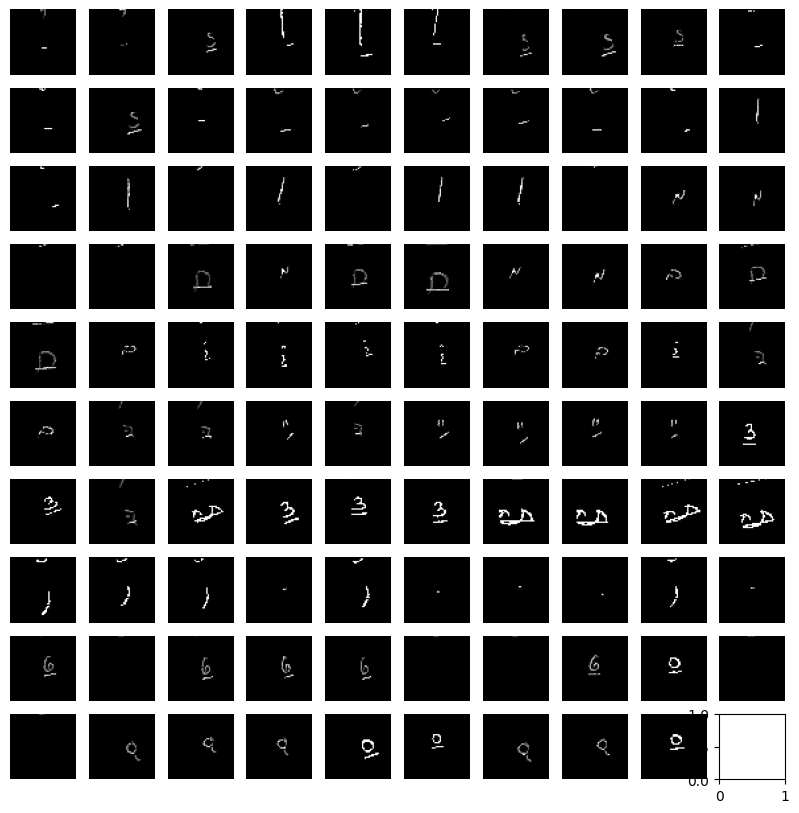

In [ ]:
def display_letters():

  train_gen = LettersGenerator(MODE_TRAIN, user_ids, model_options)
  valid_gen = LettersGenerator(MODE_VALIDATION, user_ids, model_options)

  train_gen.on_epoch_end()
  for i, (batch_x, labels) in enumerate(train_gen):
    #pass
    show_sequence(batch_x)
    break
    #for id, letter in enumerate(batch_x):
    #  print(labels[id])
    #  #image_dots(letter.squeeze()*255)
    #  show_line(letter.squeeze())
    #break


    #break
  train_gen.on_epoch_end()

full_data_set = DataSet()
display_letters()

In [ ]:
def display_triplets():
  user_ids = [1,5,15,14,46,25,]
  train_gen = TripletsGenerator(user_ids, model_options)
  valid_gen = TripletsGenerator(user_ids, model_options)

  train_gen.on_epoch_end()
  for i, (batch_x, labels) in enumerate(train_gen):
    for id, triplet in enumerate(batch_x):
      show_triplet(triplet)




    #break
  train_gen.on_epoch_end()

#full_data_set = DataSet()
display_triplets()

TypeError: ignored

In [ ]:
train_gen

NameError: ignored

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Attention, TimeDistributed
class CnnLstmAttentionModel:
    def __init__(self, options):
        self.options = options

    def get_model(self):
        input_shape = (self.options.max_sequence_length, self.options.image_height, self.options.image_width, self.options.num_channels)
        inputs = Input(shape=input_shape)

        # Create CNN layers for each image in the sequence
        image_sequences = tf.unstack(inputs, axis=1)

        cnn_outputs = [self.create_cnn_layers(image) for image in image_sequences]
        #print(f'{len(cnn_outputs)}x{cnn_outputs[0]}')
        cnn_outputs = tf.stack(cnn_outputs, axis=1)

        #print(f'{cnn_outputs.shape}')
        x = LSTM(self.options.lstm_units, return_sequences=True)(cnn_outputs)
        x = Attention()([x, x])

        # Softmax layer for classification
        outputs = Dense(self.options.num_classes, activation='softmax')(x)

        model = Model(inputs=inputs, outputs=outputs)
        return model

    def create_cnn_layers(self, inputs):
        x = Conv2D(32, (3, 3), activation='relu')(inputs)
        x = MaxPooling2D((2, 2))(x)
        x = Conv2D(64, (3, 3), activation='relu')(x)
        x = MaxPooling2D((2, 2))(x)
        x = Conv2D(128, (3, 3), activation='relu')(x)
        x = MaxPooling2D((2, 2))(x)
        x = Flatten()(x)
        return x

In [ ]:
from tensorflow import expand_dims


data_generator_collection = DataGeneratorsCollection(options=model_options)

train_gen = TrainDataGenerator(user_ids, model_options, data_generator_collection)
valid_gen = ValidationDataGenerator(user_ids, model_options, data_generator_collection)
test_gen = TestDataGenerator(user_ids, model_options, data_generator_collection)
classifier = CnnLstmAttentionModel(model_options)
model = classifier.get_model()

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'], run_eagerly=True)
#model.summary()

history = model.fit(tf.expand_dims(train_gen,axis=-1), epochs=num_epochs, batch_size=model_options.batch_size,
                   validation_data=expand_dims(valid_gen, axis=-1), verbose=1)


In [ ]:
class SimpleCnnModel:
    def get_model(self, input_shape,num_classes ):
        model = Sequential()

        # Add layers
        model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dense(num_classes, activation='softmax'))  # number of neurons equals number of classes
        return model

In [ ]:
class EmbeddingModel:
    def get_model(self, input_shape):
        input_layer = Input(shape=input_shape)

        # Convolutional layers
        x = Conv2D(32, (3, 3), activation='relu')(input_layer)
        x = MaxPooling2D((2, 2))(x)
        x = Conv2D(64, (3, 3), activation='relu')(x)
        x = MaxPooling2D((2, 2))(x)
        x = Conv2D(128, (3, 3), activation='relu')(x)
        x = MaxPooling2D((2, 2))(x)

        # Flatten and Dense layers for embeddings
        x = Flatten()(x)
        embeddings = Dense(256, activation='relu')(x)

        emb_model = Model(inputs=input_layer, outputs=embeddings)
        emb_model.compile(optimizer='adam', loss=triplet_loss)
        return emb_model


_margin = 0.2  # Triplet Loss Margin


def triplet_loss(y_true, y_pred):
    anchor, positive, negative = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2]
    positive_dist = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
    negative_dist = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
    loss = tf.maximum(0.0, positive_dist - negative_dist + _margin)
    return tf.reduce_mean(loss)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input


class CustomCNN:
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def get_model(self, options):
        model = Sequential()
        model.add(Input(shape=self.input_shape))

        # Adding Convolutional Layers
        for i in range(options['depth']):
            model.add(Conv2D(filters=options['filters'][i],
                             kernel_size=options['kernel_sizes'][i],
                             strides=options['strides'][i],
                             padding=options['padding'][i]))
            model.add(Activation(options['conv_activation']))
            if options['pooling'][i]:
                model.add(MaxPooling2D(pool_size=options['pool_sizes'][i],
                                       strides=options['pool_strides'][i]))

        model.add(Flatten())  # Flattening the 2D arrays for fully connected layers

        # Adding Fully Connected Layers
        for i in range(options['fc_layers']):
            model.add(Dense(options['fc_units'][i]))
            model.add(Activation(options['fc_activation']))
            model.add(Dropout(options['dropout_rate']))

        # Output Layer
        model.add(Dense(options['num_classes'], activation='softmax'))

        return model




for 150x150

In [ ]:
layers_options = {
    'depth': 5,  # number of convolutional layers
    'filters': [96, 256, 384, 384, 256],  # number of filters for each conv layer
    'kernel_sizes': [(11, 11), (5, 5), (3, 3), (3, 3), (3, 3)],  # filter sizes
    'strides': [(4, 4), (1, 1), (1, 1), (1, 1), (1, 1)],  # strides for each conv layer
    'padding': ['valid', 'same', 'same', 'same', 'same'],  # padding for each conv layer
    'conv_activation': 'relu',  # activation function for the convolutional layers
    'pooling': [True, True, False, False, True],  # whether to include a pooling layer after each conv layer
    'pool_sizes': [(3, 3), (3, 3), None, None, (3, 3)],  # sizes of the pooling filters
    'pool_strides': [(2, 2), (2, 2), None, None, (2, 2)],  # strides for each pooling layer
    'fc_layers': 2,  # number of fully connected layers
    'fc_units': [150, model_options.num_classes],  # number of units in each fully connected layer
    'fc_activation': 'relu',  # activation function for the fully connected layers
    'dropout_rate': 0.1,  # dropout rate
    'num_classes':model_options.num_classes   # number of classes in the output layer
}

for 50x50

In [ ]:
layers_options = {
    'depth': 5,
    'filters': [96, 256, 384, 384, 256],
    'kernel_sizes': [(4, 4), (3, 3), (3, 3), (3, 3), (3, 3)],
    'strides': [(2, 2), (1, 1), (1, 1), (1, 1), (1, 1)],
    'padding': ['valid', 'same', 'same', 'same', 'same'],
    'conv_activation': 'relu',
    'pooling': [True, True, False, False, True],
    'pool_sizes': [(2, 2), (2, 2), None, None, (2, 2)],
    'pool_strides': [(2, 2), (2, 2), None, None, (2, 2)],
    'fc_layers': 3,
    'fc_units': [1024, 1024, model_options.num_classes],
    'fc_activation': 'relu',
    'dropout_rate': 0.1,
    'num_classes': model_options.num_classes
}

In [ ]:
user_ids

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [ ]:
from keras.callbacks import ModelCheckpoint

filepath = MODEL_CHECKPOINT_PATH + "model-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

num_epochs=30
user_ids =[i for i in range(12,22)]

model_options = ModelOptions(
    num_classes=len(user_ids),
    batch_size=1000,
    image_height=150,
    image_width=150,
    num_channels=1,
    max_sequence_length=40,
    random_shuffle_amount=2
)

layers_options = {
    'depth': 5,  # number of convolutional layers
    'filters': [96, 256, 384, 384, 256],  # number of filters for each conv layer
    'kernel_sizes': [(11, 11), (5, 5), (3, 3), (3, 3), (3, 3)],  # filter sizes
    'strides': [(4, 4), (1, 1), (1, 1), (1, 1), (1, 1)],  # strides for each conv layer
    'padding': ['valid', 'same', 'same', 'same', 'same'],  # padding for each conv layer
    'conv_activation': 'relu',  # activation function for the convolutional layers
    'pooling': [True, True, False, False, True],  # whether to include a pooling layer after each conv layer
    'pool_sizes': [(3, 3), (3, 3), None, None, (3, 3)],  # sizes of the pooling filters
    'pool_strides': [(2, 2), (2, 2), None, None, (2, 2)],  # strides for each pooling layer
    'fc_layers': 3,  # number of fully connected layers
    'fc_units': [1024, 512, model_options.num_classes],  # number of units in each fully connected layer
    'fc_activation': 'relu',  # activation function for the fully connected layers
    'dropout_rate': 0.1,  # dropout rate
    'num_classes':model_options.num_classes   # number of classes in the output layer
}

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# If a GPU is available, the TensorFlow should default to it
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")



input_shape = (model_options.image_height,model_options.image_width ,1)
num_classes = len(user_ids)
train_gen = LettersGenerator(MODE_TRAIN,user_ids, model_options)
valid_gen = LettersGenerator(MODE_VALIDATION, user_ids, model_options)

sm = CustomCNN(input_shape)
model = sm.get_model(layers_options)

opt =  Adam(learning_rate=1e-5)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
history = model.fit(train_gen, epochs=num_epochs, batch_size=model_options.batch_size,
                    validation_data=valid_gen, verbose=1, callbacks=callbacks_list)

Num GPUs Available:  1
Default GPU Device: /device:GPU:0
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 35, 35, 96)        11712     
                                                                 
 activation_24 (Activation)  (None, 35, 35, 96)        0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 17, 17, 96)       0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 17, 17, 256)       614656    
                                                                 
 activation_25 (Activation)  (None, 17, 17, 256)       0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 8, 8, 256)        0       

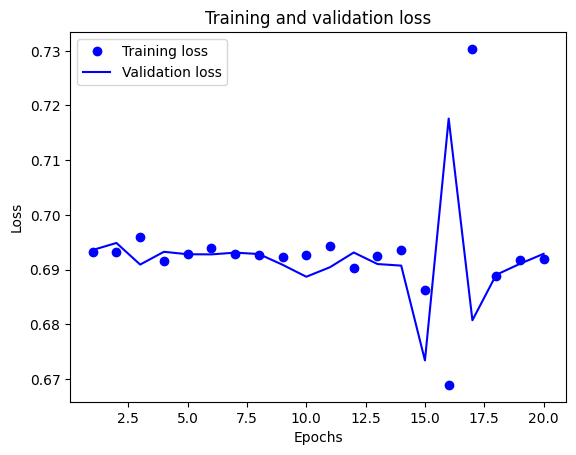

In [ ]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc  = history_dict['accuracy']
epochs = range(1, len(acc) + 1)
plt.clf()
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

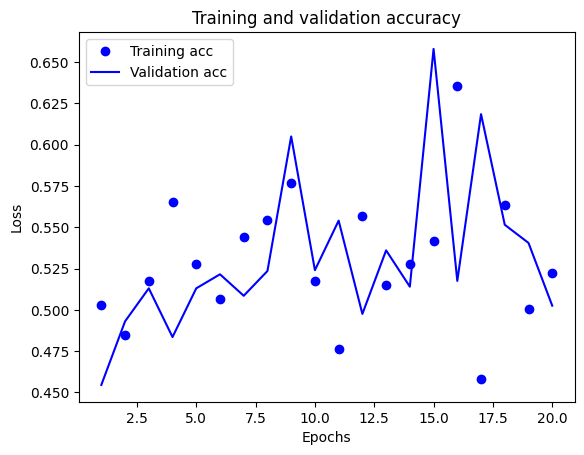

In [ ]:
plt.clf()
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
x= tf.reshape(tf.range(12), (3,4))
print(x)
tf.unstack(x, axis=1)



tf.Tensor(
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]], shape=(3, 4), dtype=int32)


[<tf.Tensor: shape=(3,), dtype=int32, numpy=array([0, 4, 8], dtype=int32)>,
 <tf.Tensor: shape=(3,), dtype=int32, numpy=array([1, 5, 9], dtype=int32)>,
 <tf.Tensor: shape=(3,), dtype=int32, numpy=array([ 2,  6, 10], dtype=int32)>,
 <tf.Tensor: shape=(3,), dtype=int32, numpy=array([ 3,  7, 11], dtype=int32)>]

In [ ]:
uid = [1,5,6,8,18,64,54]
print(uid.index(54))
print(len(uid))

6
7
